# Deep-Q-Learning

In this notebook I explore the concepts of Deep-Q-Learning by following the papers published DeepMind [V. Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf) and [V. Mnih et al (2015)](https://www.nature.com/articles/nature14236/).

As I'm intrigued by the topic of autonomous driving, the [MIT lecture videos by Lex Fridman](https://deeplearning.mit.edu/) introduced me to the topic of DQL motivated me to take a deep dive and get familiar with its concepts.

### !!!This is still a work in progress!!!

In [19]:
import gym
import numpy as np
import random

import tensorflow as tf
from tensorflow import keras
from keras.layers import Conv2D, Flatten, Dense

import typing

import matplotlib.pyplot as plt

from skimage.transform import resize
from PIL import Image

## Preview of the game

Use **left** and **right arrows** to move the spaceship sideways and the **space bar** to use the main cannon and shoot the aliens!

If you want to move to the left/right and shoot simultaneously then use **s/d**.

As you play, the `PlayPlot` function (marked deprecated) will plot the immediate award for the actions you take. For this uncomment the callback call in the `play` function. 

In [3]:
import pygame
from gym.utils.play import play, PlayPlot

def compute_metrics(obs_t, obs_tp, action, reward, terminated, truncated, info):
    return [reward, np.linalg.norm(action)]

plotter = PlayPlot(
    compute_metrics,
    horizon_timesteps=200,
    plot_names=["Immediate Rew.", "Action Magnitude"]
)

my_env = gym.make("SpaceInvaders-v4", render_mode="rgb_array")
mapping = {(pygame.K_SPACE,): 1, (pygame.K_RIGHT,): 2, (pygame.K_LEFT,): 3, (pygame.K_d,): 4, (pygame.K_s,): 5}
play(my_env, keys_to_action=mapping) #, callback=plotter.callback)

/home/hare/.local/lib/python3.10/site-packages/gym/utils/play.py:322: DeprecationWarning: WARN: `PlayPlot` is marked as deprecated and will be removed in the near future.
  deprecation(
A.L.E: Arcade Learning Environment (version 0.8.0+919230b)
[Powered by Stella]
ERROR: PlayableGame wrapper works only with rgb_array and rgb_array_list render modes, but your environment render_mode = None.
/home/hare/.local/lib/python3.10/site-packages/gym/utils/passive_env_checker.py:289: UserWarning: WARN: No render fps was declared in the environment (env.metadata['render_fps'] is None or not defined), rendering may occur at inconsistent fps.
  logger.warn(


## Some random action taken

In [ ]:
import gym
env = gym.make("SpaceInvaders-v4", render_mode="human")
observation, info = env.reset(seed=42)
for _ in range(1000):
    action = choose_action(env, observation, 1)
    observation, reward, terminated, truncated, info = env.step(action)

    if terminated or truncated:
        observation, info = env.reset()
env.close()

## Starting to define some functions

For the first attempt we'll use the architecture of the neural network described on page 6 in [Volodymir Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf).

### Preprocess function $\phi$

Since it will be computationally more demanding working with the raw $210 \times 160$ pixel frames, we'll apply a preprocess function $\phi$ to the frames before forwarding them to the neural network. The preprocess function will do the following
- (will not be done here) for a single frame we take the maximum value for each pixel color value and the previous frame (removes flickering in original paper, but we'll use the `ALE/SpaceInvaders-v5` environment which has a frameskip=5 which removes the flickering of the misiles)
- the frames will be converted from RGB representation into gray-scale
- the frames will be resized to $110 \times 84$ images
- the playing area is cropped out so we have a final $84 \times 84$ frame (this is done in, but I might skip this step in this notebook [Volodymir Mnih et al (2013)](https://arxiv.org/pdf/1312.5602.pdf))
- the last 4 frames from a sequence will be modified as explained and stacked to form a $84 \times 84 \times 4$ input for the agent

So, to preprocess our input for the neuarl network, we'll need a function $\phi$ that will take the previous processed sequence $\phi_t$ and new obtained frame $x_{t+1}$ and combine them to a new processed sequence as follows

$$\phi: \phi_t, x_{t+1} \longrightarrow \phi_{t+1}$$

In [3]:
class Preprocessor:
    """
    Takes care of preprocessing frames for the models.
    """
    
    def __init__(self, height:int=84, width:int=84):
        self.height = height
        self.width = width
        
        
    def encode_frames(self, new_raw_obs, old_raw_obs):
        return np.array([old_raw_obs, new_raw_obs]).max(axis=0)    
    
    # look up additional annotations to add
        # what does the numpy array consist of
        # what does the tf.tensor consist of, it's shape and type
    def preprocess_frame(self, new_raw_obs:np.ndarray, old_raw_obs:np.ndarray) -> tf.uint8:
        """
        Preprocesses one frame for the model.
        Args:
            new_raw_obs: new raw frame with shape (210, 160, 3)
            old_raw_obs: previous raw frame with shape (210, 160, 3)
        Returns:
            processed frame with shape (84, 84, 1)
        """
        
        processed_fr = self.encode_frames(old_raw_obs, new_raw_obs)
        processed_fr = tf.image.rgb_to_grayscale(processed_fr)
        processed_fr = tf.image.crop_to_bounding_box(processed_fr, 34, 0, 160, 160)
        processed_fr = tf.image.resize(processed_fr, [self.height, self.width], method='bilinear')
        processed_fr = tf.cast(processed_fr, tf.uint8)

        return processed_fr
    
    def initialize_state(self, env) -> tf.uint8:
        """
        Initializes the first state of an episode with the first 4 frames.
        Args:
            new_raw_obs: new raw frame with shape (210, 160, 3)
        Returns:
            state containing the first four preprocessed frames with shape (84, 84, 4)
        """
        env.reset()
        actions = [env.action_space.sample() for i in range(5)]
        raw_frames = [env.step(action)[0] for action in actions]
        processed_frames = [self.preprocess_frame(raw_frames[idx], raw_frames[idx+1]) for idx in range(4)]
        
        return tf.concat(processed_frames, axis=-1), raw_frames[-1]
        
    
    def new_state(self, new_raw_obs:np.ndarray, old_raw_obs:np.ndarray, old_state:tf.uint8) -> tf.uint8:
        """
        Creates a news state from an old state and a new raw frame.
        Args:
            new_raw_obs: new raw frame with shape (210, 160, 3)
            old_state: old state consisting of four preprocessed previous frames (84, 84, 4)
        Returns:
            new state with shape (84, 84, 4) where the new preprocessed frame was appended to the old 
            state and the oldest preprocessed frame was dropped.
        """
        processed_fr = self.preprocess_frame(new_raw_obs, old_raw_obs)
        
        return tf.concat([old_state[::, ::, 1:], processed_fr], axis=-1)

### Testing the preprocess function $\phi$

In [14]:
## get some observations to test the preprocess function
## first 45 memory entries are before the game starts

def get_sample_frames(name="SpaceInvaders-v4", frameskip=5):

    memory_raw = []
    memory_processed = []
    memory_encoded = []

    some_preprocessor = Preprocessor()
    
    if frameskip:
        env = gym.make(name, frameskip=frameskip, render_mode="rgb_array")
    else:
        env = gym.make(name, render_mode="rgb_array")
        
    preprocessed, curr_raw_obs = some_preprocessor.initialize_state(env)
    memory_processed.append(preprocessed)
    memory_raw.append(curr_raw_obs)
    for _ in range(500):
        action = env.action_space.sample()
        new_raw_obs, reward, terminated, truncated, info = env.step(action)

        preprocessed = some_preprocessor.new_state(new_raw_obs, curr_raw_obs, memory_processed[-1])
        memory_processed.append(preprocessed)
        
        encoded = some_preprocessor.encode_frames(new_raw_obs, curr_raw_obs)
        memory_encoded.append(encoded)
        
        curr_raw_obs = new_raw_obs
        memory_raw.append(curr_raw_obs)

        if terminated or truncated:
            observation, info = env.reset()
    env.close()
    
    return memory_raw, memory_processed, memory_encoded

In [5]:
# defining a couple of functions to check the original and processed frames
    # check if the flickering is a problem in consecutive images
    # check if the misiles are seen in the processed images


def plot_raw_frames(frames):

    fig = plt.figure(figsize=(10, 10))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        img = frames[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img)
    plt.show()
    
def plot_processed_frames(frames):

    fig = plt.figure(figsize=(10, 10))
    columns = 4
    rows = 1
    for i in range(1, columns*rows +1):
        img = frames[i]
        fig.add_subplot(rows, columns, i)
        plt.imshow(img[::, ::, 2])
    plt.show()

### Exploration and exploitation with $\epsilon$-greedy strategy

- explore for rand < eps and exploit for rand > eps
- for first xx amount of frames $\epsilon = 1$
- for the next million frames $\epsilon \rightarrow 0.1$ linearly
- after that it is fixed to $\epsilon = 0.1$

In [6]:
class ExplorationVsExploitation:
    """
        This class handles the epsilon-greedy strategy which will be used to determine whethere
        we will choose an action to explore new possibilites or exploit the accumulated experience.
    """
    def __init__(self,
                 dqn_model,
                 n_actions:int,
                 eps_initial:float=1.0,
                 eps_final:float=0.1,
                 start_fr:int=5000,
                 end_fr:int=1000000,
                 evaluation:bool=False):
        """
            Args:
                dqn_model
                n_actions
                eps_initial
                eps_final
                start_fr
                end_fr
        """
        self.eps_initial = eps_initial
        self.eps_final = eps_final
        self.start_fr = start_fr
        self.end_fr = end_fr
        self.slope = (self.eps_initial - self.eps_final) / (self.start_fr - self.end_fr)
        self.intercept = eps_initial - self.slope * self.start_fr
        
        self.n_actions = n_actions
        
        self.dqn_model = dqn_model
        
        self.evaluation = evaluation
        
        
    def __call__ (self, curr_state:tf.uint8, frame_num:int=0) -> int:
        """
            Args:
                curr_state: Current state of the game which will be used if we opt out for exploitation.
                frame_num: Number of frame which is being processed.
        """
        if self.evaluation:
            eps = 0
        elif frame_num <= self.start_fr:
            eps = self.eps_initial
        elif self.start_fr < frame_num < self.end_fr:
            eps = self.slope * frame_num + self.intercept
        elif frame_num >= self.end_fr:
            eps = self.eps_final
        
        if np.random.rand() < eps:
            # we explore
            return np.random.randint(self.n_actions)
        else:
            # we choose the action yielding the highest reward according to our model
            model_prediction = self.dqn_model.best_action(tf.expand_dims(curr_state, axis=0))
            return model_prediction


### Defining the agent

Text about the DQN model coming soon.

- create a target model updater
- check why accuracy always 0% -> because its not a categorical problem
- create an evaluation process
- get an output gif/video of the model actually playing

In [7]:
huber = tf.keras.losses.Huber()

class MaxValAndAction(keras.layers.Layer):
        def __init__(self):
            super(MaxValAndAction, self).__init__()
        
        def __call__(self, values):
            action = tf.cast(tf.math.argmax(values, axis=1), dtype=tf.float64)
            max_value = tf.cast(tf.math.reduce_max(values, axis=1), dtype=tf.float64)
            
            return tf.stack([max_value, action], axis=1)
        
def custom_loss(y_true, y_pred):
    # y_true shape -> (batch_size, 1) first is the number of examples processed, second is maxval
    # y_pred shape -> (batch_size, 2) first is the number of examples processed, second is maxval, action
    # we only need maxval for the loss function

    #loss = tf.math.reduce_mean(tf.math.square(tf.subtract(y_true[::,0], y_pred[::,0]))) #mse(y_true[::,0], y_pred[::,0])
    loss = huber(y_true[::,0], y_pred[::,0])
    return loss

In [8]:
class DQN_model:
    def __init__(self, n_actions:int, learning_rate:float=0.001, state_shape:tuple=(84,84,4)):
        """
        Args:
            n_actions:
            learning_rate:
            state_shape:
        """
        
        # We initalize a keras model according to the proposed architecture in Volodymir Mnih et al (2015)
            # to do: check if it is needed to define something more custom for DQN
        self.model = keras.Sequential()
        
        # check input shapes for each layer
        self.model.add(Conv2D(filters=32, kernel_size=(8, 8), strides=(4, 4), padding="same", activation="relu", input_shape=state_shape))
        self.model.add(Conv2D(filters=64, kernel_size=(4, 4), strides=(2, 2), padding="same", activation="relu"))
        self.model.add(Conv2D(filters=64, kernel_size=(3, 3), strides=(1, 1), padding="same", activation="relu"))
        self.model.add(Flatten())
        self.model.add(Dense(512, activation="relu"))
        self.model.add(Dense(n_actions, activation="linear"))
        self.model.add(MaxValAndAction())
        
        self.model.compile(loss=custom_loss, optimizer=keras.optimizers.Adam(learning_rate=learning_rate))
    
    def best_action(self, new_state):
        model_prediction = self.model.predict(new_state, verbose=0)
        return int(model_prediction[0][1])
    
    def predict(self, new_state):
        model_prediction = self.model.predict(new_state, verbose=0)
        return model_prediction[0][0]
    
    def get_weights(self):
        return self.model.get_weights()
    
    def set_weights(self, weights):
        self.model.set_weights(weights)
        
    def update_step(self, target_model, replay_memory):
        """
        Args:
            target_model                
        """
        # sample minibatch of transitions
        minibatch = replay_memory.sample_minibatch()
        target_q = []
        X = []

        # for each transition we need a target value Q
        for (idx, (curr_state, curr_action, reward, new_state, lives)) in enumerate(minibatch):
            X.append(curr_state)
            if lives == 0:
                target_q.append(reward)
            else:
                new_state = tf.expand_dims(new_state, axis=0)
                target_pred = target_model.predict(new_state)
                target_q.append(reward + discount * target_pred)

        # update the weights of the main model with target values Q
        training_info = self.model.fit(x=np.array(X), y=np.array(target_q), epochs=1, verbose=2)
        return training_info.history['loss'][0]


### Replay memory

The replay memory D stores following information (called *transition*) every step

$$\left( \phi_t, \ a_t, \ r_t, \ \phi_{t+1} \right) \longrightarrow D$$

where
- $\phi_t$ is the preprocessed sequence including the frame at time step $t$
- $a_t$ is the action taken at time step $t$
- $r_t$ is the reward gained at time step $t$ after taking action $a_t$ in state $\phi_t$ $t$
- $\phi_{t+1}$ is the preprocessed sequence including the new state we reached after taking action $a_t$

In [9]:
class replay_memory:
    def __init__(self, capacity, minibatch_size):
        self.capacity = capacity
        self.memories = []
        self.minibatch_size = minibatch_size
        
    def store_transition(self, curr_state, curr_action, reward, new_state, lives):
        """
        Stores a transition in replay_memory.
        """
        self.memories.append([curr_state, curr_action, reward, new_state, lives])
        if (len(self.memories) > self.capacity):
            self.memories.pop(0)
    def sample_minibatch(self):
        """
        Samples a minibatch of transitions from replay_memory.
        """
        return random.sample(self.memories, self.minibatch_size)
    
    def get_memories(self):
        return self.memories
    
    def get_count_of_memories(self):
        return len(self.memories)

In [45]:
my_env = gym.make("ALE/SpaceInvaders-v5", frameskip=5, render_mode="rgb_array")
obs_shape = my_env.observation_space.shape
num_actions = my_env.action_space.n

memory_size = 10**6
num_of_episodes = 10
minibatch_size = 32
update_target_freq = 10**4    ## update target NN every 5 parameter updates (steps)
discount = 0.99
action_repeat = 4         ## repeat chosen action 4 times
update_main_freq = 4      ## SGD update main NN after 4 chosen actions
learning_rate = 0.001
grad_mom = 0.95
sq_grad_mom = 0.95
min_sq_grad = 0.01
eps = 0

memory_warm_up = 1500

## Training the model with the Deep-Q-learning Algorithm

Training details:
- We will follow [V. Mnih et al (2015)](https://www.nature.com/articles/nature14236/) and normalize the positive, neutral and negative rewards to 1, 0, -1 respectively

In [46]:
def normalize_rewards(rew):
    return 1 if rew > 0 else -1 if rew < 0 else 0    

In [47]:
## initialize action-value function Q with random weights
M_model = DQN_model(num_actions)

## initialize action-value target function with same weights 
T_model = DQN_model(num_actions)
T_model.set_weights(M_model.get_weights())

In [48]:
def train_DQL():
    ## initialize replay memory D
    memories = replay_memory(memory_size, minibatch_size)
    
    ## initialize epsilon greedy scheduler
    explore_vs_exploit = ExplorationVsExploitation(M_model, num_actions)
    
    ## initialize frame preprocessor
    Frame_processor = Preprocessor()

    memory_count = frame_num = 0
    
    losses = []
    rewards = []
    
    ## start outer loop of the number of episode we'll train the model for
    for episode in range(num_of_episodes):
        
        episode_reward = 0

        ## initialise sequence s1 = {x1} and preprocessed the sequence
        curr_state, curr_raw_obs = Frame_processor.initialize_state(my_env)
        alive = True
        
        while alive:
            
            ## choose an exploration/explotation action 
            curr_action = explore_vs_exploit(curr_state, frame_num)
            
            ## take action
            new_raw_obs, reward, terminated, truncated, info = my_env.step(curr_action)
            
            if info["lives"] == 0:
                alive = False
            
            episode_reward += reward

            reward = normalize_rewards(reward)

            ## create new sequence with new frame
            new_state = Frame_processor.new_state(new_raw_obs, curr_raw_obs, curr_state)

            ## store new transition
            memories.store_transition(curr_state, curr_action, reward, new_state, info["lives"])
            memory_count +=1
            
            ## perform weights update for main model
            if frame_num % update_main_freq == 0 and frame_num > memory_warm_up:
                loss = M_model.update_step(T_model, memories)
                losses.append(loss)
            
            ## perform weights update for target model
            if frame_num % update_target_freq == 0 and frame_num > memory_warm_up:
                T_model.set_weights(M_model.get_weights())

            curr_state = new_state
            curr_raw_obs = new_raw_obs
            frame_num += 1
                
        print('frame_nummmmmm', frame_num)
        rewards.append(episode_reward)
        
    return losses, rewards
            

In [49]:
some_losses, some_rewards = train_DQL()

frame_nummmmmm 490
frame_nummmmmm 775
1/1 - 1s - loss: 0.2896 - 1s/epoch - 1s/step
1/1 - 0s - loss: 23.3071 - 71ms/epoch - 71ms/step
1/1 - 0s - loss: 11.6692 - 67ms/epoch - 67ms/step
1/1 - 0s - loss: 6.2359 - 70ms/epoch - 70ms/step
1/1 - 0s - loss: 2.8127 - 87ms/epoch - 87ms/step
1/1 - 0s - loss: 2.9844 - 63ms/epoch - 63ms/step
1/1 - 0s - loss: 3.0306 - 67ms/epoch - 67ms/step
1/1 - 0s - loss: 2.7236 - 74ms/epoch - 74ms/step
1/1 - 0s - loss: 1.7519 - 64ms/epoch - 64ms/step
1/1 - 0s - loss: 0.9718 - 68ms/epoch - 68ms/step
1/1 - 0s - loss: 1.8256 - 86ms/epoch - 86ms/step
1/1 - 0s - loss: 1.3802 - 68ms/epoch - 68ms/step
1/1 - 0s - loss: 0.8601 - 67ms/epoch - 67ms/step
1/1 - 0s - loss: 1.0953 - 85ms/epoch - 85ms/step
1/1 - 0s - loss: 1.7867 - 75ms/epoch - 75ms/step
1/1 - 0s - loss: 1.2380 - 69ms/epoch - 69ms/step
1/1 - 0s - loss: 1.0354 - 71ms/epoch - 71ms/step
1/1 - 0s - loss: 0.8050 - 78ms/epoch - 78ms/step
1/1 - 0s - loss: 0.8287 - 71ms/epoch - 71ms/step
1/1 - 0s - loss: 1.1164 - 71ms/ep

1/1 - 0s - loss: 0.1520 - 87ms/epoch - 87ms/step
1/1 - 0s - loss: 0.3027 - 66ms/epoch - 66ms/step
1/1 - 0s - loss: 0.2198 - 57ms/epoch - 57ms/step
1/1 - 0s - loss: 0.1860 - 76ms/epoch - 76ms/step
1/1 - 0s - loss: 0.2527 - 85ms/epoch - 85ms/step
1/1 - 0s - loss: 0.2485 - 59ms/epoch - 59ms/step
1/1 - 0s - loss: 0.2718 - 63ms/epoch - 63ms/step
1/1 - 0s - loss: 0.3055 - 82ms/epoch - 82ms/step
1/1 - 0s - loss: 0.2861 - 68ms/epoch - 68ms/step
1/1 - 0s - loss: 0.2214 - 72ms/epoch - 72ms/step
1/1 - 0s - loss: 0.2927 - 88ms/epoch - 88ms/step
1/1 - 0s - loss: 0.2249 - 66ms/epoch - 66ms/step
1/1 - 0s - loss: 0.1130 - 66ms/epoch - 66ms/step
1/1 - 0s - loss: 0.1729 - 87ms/epoch - 87ms/step
1/1 - 0s - loss: 0.1802 - 80ms/epoch - 80ms/step
1/1 - 0s - loss: 0.1450 - 65ms/epoch - 65ms/step
1/1 - 0s - loss: 0.1883 - 66ms/epoch - 66ms/step
1/1 - 0s - loss: 0.2786 - 95ms/epoch - 95ms/step
1/1 - 0s - loss: 0.3909 - 138ms/epoch - 138ms/step
1/1 - 0s - loss: 0.1501 - 53ms/epoch - 53ms/step
1/1 - 0s - loss: 0

1/1 - 0s - loss: 0.1027 - 63ms/epoch - 63ms/step
1/1 - 1s - loss: 0.1908 - 638ms/epoch - 638ms/step
1/1 - 0s - loss: 0.0821 - 50ms/epoch - 50ms/step
1/1 - 0s - loss: 0.1647 - 105ms/epoch - 105ms/step
1/1 - 0s - loss: 0.2334 - 70ms/epoch - 70ms/step
1/1 - 0s - loss: 0.1991 - 66ms/epoch - 66ms/step
1/1 - 0s - loss: 0.1893 - 48ms/epoch - 48ms/step
1/1 - 0s - loss: 0.1326 - 48ms/epoch - 48ms/step
1/1 - 0s - loss: 0.1347 - 96ms/epoch - 96ms/step
1/1 - 0s - loss: 0.1895 - 51ms/epoch - 51ms/step
1/1 - 0s - loss: 0.1916 - 86ms/epoch - 86ms/step
1/1 - 0s - loss: 0.0927 - 54ms/epoch - 54ms/step
1/1 - 0s - loss: 0.1410 - 51ms/epoch - 51ms/step
1/1 - 0s - loss: 0.1979 - 51ms/epoch - 51ms/step
1/1 - 0s - loss: 0.1618 - 65ms/epoch - 65ms/step
1/1 - 0s - loss: 0.1370 - 51ms/epoch - 51ms/step
1/1 - 0s - loss: 0.1095 - 51ms/epoch - 51ms/step
1/1 - 0s - loss: 0.2112 - 59ms/epoch - 59ms/step
1/1 - 0s - loss: 0.3445 - 49ms/epoch - 49ms/step
1/1 - 0s - loss: 0.1372 - 52ms/epoch - 52ms/step
1/1 - 0s - loss:

1/1 - 0s - loss: 0.1720 - 49ms/epoch - 49ms/step
1/1 - 0s - loss: 0.2143 - 63ms/epoch - 63ms/step
1/1 - 0s - loss: 0.1379 - 50ms/epoch - 50ms/step
1/1 - 0s - loss: 0.2043 - 98ms/epoch - 98ms/step
1/1 - 0s - loss: 0.1035 - 49ms/epoch - 49ms/step
1/1 - 0s - loss: 0.1236 - 48ms/epoch - 48ms/step
1/1 - 0s - loss: 0.2640 - 50ms/epoch - 50ms/step
1/1 - 0s - loss: 0.1742 - 50ms/epoch - 50ms/step
1/1 - 0s - loss: 0.1687 - 50ms/epoch - 50ms/step
1/1 - 0s - loss: 0.4712 - 52ms/epoch - 52ms/step
1/1 - 0s - loss: 0.1053 - 51ms/epoch - 51ms/step
1/1 - 0s - loss: 0.1294 - 52ms/epoch - 52ms/step
1/1 - 0s - loss: 0.3061 - 53ms/epoch - 53ms/step
1/1 - 0s - loss: 0.1949 - 49ms/epoch - 49ms/step
1/1 - 0s - loss: 0.2535 - 49ms/epoch - 49ms/step
1/1 - 0s - loss: 0.1681 - 82ms/epoch - 82ms/step
1/1 - 0s - loss: 0.2545 - 49ms/epoch - 49ms/step
1/1 - 0s - loss: 0.0948 - 65ms/epoch - 65ms/step
1/1 - 0s - loss: 0.1542 - 50ms/epoch - 50ms/step
frame_nummmmmm 3580
1/1 - 0s - loss: 0.1982 - 48ms/epoch - 48ms/step


1/1 - 6s - loss: 0.3290 - 6s/epoch - 6s/step
1/1 - 0s - loss: 0.1800 - 50ms/epoch - 50ms/step
1/1 - 0s - loss: 0.2260 - 51ms/epoch - 51ms/step
1/1 - 0s - loss: 0.3088 - 50ms/epoch - 50ms/step
1/1 - 0s - loss: 0.1997 - 49ms/epoch - 49ms/step
1/1 - 0s - loss: 0.3079 - 52ms/epoch - 52ms/step
1/1 - 0s - loss: 0.2133 - 51ms/epoch - 51ms/step
1/1 - 2s - loss: 0.2255 - 2s/epoch - 2s/step
1/1 - 0s - loss: 0.2191 - 48ms/epoch - 48ms/step
1/1 - 0s - loss: 0.2401 - 50ms/epoch - 50ms/step
1/1 - 0s - loss: 0.1630 - 54ms/epoch - 54ms/step
1/1 - 0s - loss: 0.2506 - 49ms/epoch - 49ms/step
1/1 - 0s - loss: 0.1712 - 66ms/epoch - 66ms/step
1/1 - 0s - loss: 0.2060 - 57ms/epoch - 57ms/step
1/1 - 0s - loss: 0.1627 - 57ms/epoch - 57ms/step
1/1 - 0s - loss: 0.1701 - 50ms/epoch - 50ms/step
1/1 - 0s - loss: 0.1978 - 49ms/epoch - 49ms/step
1/1 - 0s - loss: 0.2431 - 57ms/epoch - 57ms/step
1/1 - 0s - loss: 0.1586 - 56ms/epoch - 56ms/step
1/1 - 0s - loss: 0.1680 - 49ms/epoch - 49ms/step
1/1 - 0s - loss: 0.3826 - 51

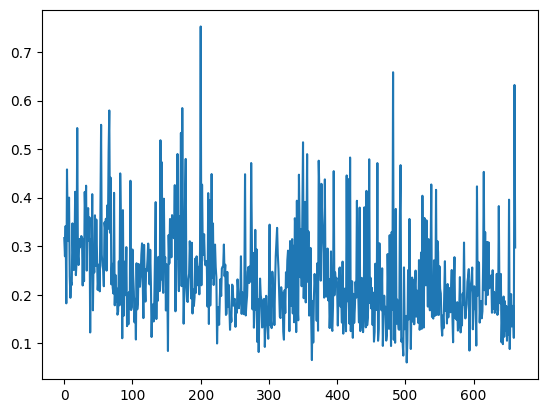

In [51]:
plt.plot(some_losses[50:])

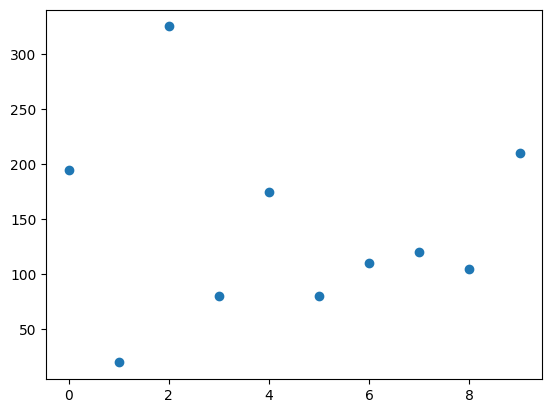

In [52]:
plt.plot(some_rewards, 'o')

<img src="./images/DQL-algorithm-2015.png" alt="dql" width="850"/>

In [53]:
def evaluate_DQL():
    ## initialize epsilon greedy scheduler
    explore_vs_exploit = ExplorationVsExploitation(M_model, num_actions, evaluation=True)
    
    ## initialize frame preprocessor
    Frame_processor = Preprocessor()

    #memory_count = frame_num = 0
    
    info = {"lives": 3}
    
    losses = []
    rewards = []
    frames_for_gif = []
    
    ## start outer loop of the number of episode we'll train the model for
    for episode in range(1):
        
        episode_reward = 0

        ## initialise sequence s1 = {x1} and preprocessed the sequence
        curr_state, curr_raw_obs = Frame_processor.initialize_state(my_env)
        
        #while (info["lives"] > 0):
        for i in range(500):
            
            ## choose an exploration/explotation action 
            curr_action = explore_vs_exploit(curr_state)
            
            ## take action
            new_raw_obs, reward, terminated, truncated, info = my_env.step(curr_action)
            
            frames_for_gif.append(new_raw_obs)
            
            episode_reward += reward

            reward = normalize_rewards(reward)

            ## create new sequence with new frame
            curr_state = Frame_processor.new_state(new_raw_obs, curr_raw_obs, curr_state)
            curr_raw_obs = new_raw_obs
               
        
        rewards.append(episode_reward)
    return losses, rewards, frames_for_gif
            

In [54]:
eval_losess, eval_rew, eval_frames = evaluate_DQL()

In [20]:
def export_as_gif(frames, name):
    resized_frames = [resize(frame, (420, 320, 3), preserve_range=True, order=0).astype(np.uint8) for frame in frames]
    
    images = [Image.fromarray(frame) for frame in resized_frames]
    
    images[0].save(name, save_all=True, append_images=images[1:], duration=100, loop=0)
    

In [56]:
export_as_gif(eval_frames, "space-invaders-v5-fs5-first_training.gif")

In [15]:
raws, processed, encoded = get_sample_frames("ALE/SpaceInvaders-v5")